# Dimensionality Reduction

## PCA

Example of sklearn's PCA use:
* from sklearn.decomposition import PCA
* pca = PCA(n_components=2)
* X2D = pca.fit_transform(X)

Instead of arbitrarily choosing the number of dimensions to reduce down to,
it is simpler to choose the number of dimensions that add up to a
sufficiently large portion of the variance—say, 95% (unless PCA is for data visualization)

The following code loads and splits the MNIST dataset and performs PCA without reducing dimensionality, then computes the minimum number of dimensions required to preserve 95% of
the training set’s variance:

In [1]:
from tensorflow import keras
from sklearn.decomposition import PCA
import numpy as np

(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1
d

np.int64(154)

You could then set n_components=d and run PCA again, but there’s a better
option. Instead of specifying the number of principal components you want
to preserve, you can set n_components to be a float between 0.0 and 1.0,
indicating the ratio of variance you wish to preserve:

In [2]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

The actual number of components is determined during training, and it is
stored in the n_components_ attribute:

In [3]:
pca.n_components_

np.int64(154)

Yet another option is to plot the explained variance as a function of the
number of dimensions. There will
usually be an elbow in the curve, where the explained variance stops
growing fast.

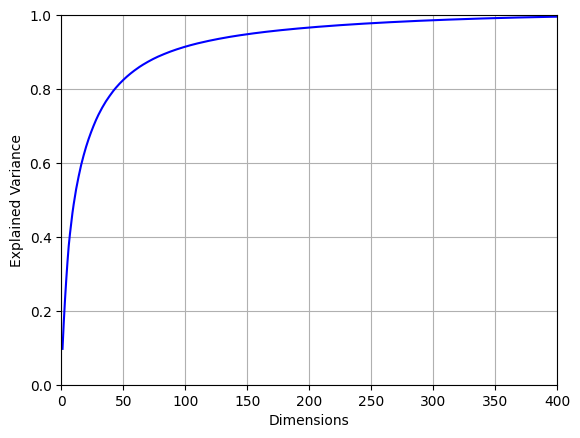

In [4]:
import matplotlib.pyplot as plt

pca = PCA()
pca.fit(X_train)
dim = range(1, len(pca.explained_variance_ratio_) + 1)
cumsum = np.cumsum(pca.explained_variance_ratio_)

plt.plot(dim, cumsum, "b-")
plt.grid()
plt.axis([0,400, 0.0, 1.0])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.show()

Lastly, if you are using dimensionality reduction as a preprocessing step for
a supervised learning task (e.g., classification), then you can tune the
number of dimensions as you would any other hyperparameter

In [5]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=20, cv=3,
                                random_state=42, n_jobs=-1)
rnd_search.fit(X_train[:1000], y_train[:1000])

,estimator,Pipeline(step...m_state=42))])
,param_distributions,"{'pca__n_components': array([10, 11... 78, 79]), 'randomforestclassifier__n_estimators': array([ 50, ...97, 498, 499])}"
,n_iter,20
,scoring,None
,n_jobs,-1
,refit,True
,cv,3
,verbose,0
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [6]:
print("Best hyperparameters found:\n", rnd_search.best_params_)

Best hyperparameters found:
 {'randomforestclassifier__n_estimators': np.int64(272), 'pca__n_components': np.int64(28)}


It is possible to transform the data back to its original number of dimensions (with some information loss):

In [7]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
X_recovered = pca.inverse_transform(X_reduced)

## Randomized PCA

If you set the svd_solver hyperparameter to "randomized", Scikit-Learn
uses a stochastic algorithm called randomized PCA that quickly finds an
approximation of the first d principal components. Its computational
complexity is O(m × d^2) + O(d^3), instead of O(m × n^2) + O(n^3) for the full
SVD approach.

where:
* m = number of instances
* n = number of dimensions
* d = number of the first principal components

In [8]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

                                TIP
By default, svd_solver is actually set to "auto": Scikit-Learn automatically uses the
randomized PCA algorithm if max(m, n) > 500 and n_components is an integer smaller
than 80% of min(m, n), or else it uses the full SVD approach. So the preceding code
would use the randomized PCA algorithm even if you removed the
svd_solver="randomized" argument, since 154 < 0.8 × 784. If you want to force
Scikit-Learn to use full SVD for a slightly more precise result, you can set the
svd_solver hyperparameter to "full"

## Incremental PCA

One problem with the preceding implementations of PCA is that they
require the whole training set to fit in memory in order for the algorithm to
run. Fortunately, incremental PCA (IPCA) algorithms have been developed
that allow you to split the training set into mini-batches and feed these in
one mini-batch at a time.

In [9]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduce = inc_pca.transform(X_train)

Alternatively, you can use NumPy’s memmap class, which allows you to
manipulate a large array stored in a binary file on disk as if it were entirely
in memory; the class loads only the data it needs in memory, when it needs
it. To demonstrate this, let’s first create a memory-mapped (memmap) file
and copy the MNIST training set to it, then call flush() to ensure that any
data still in the cache gets saved to disk. In real life, X_train would
typically not fit in memory, so you would load it chunk by chunk and save
each chunk to the right part of the memmap array:

In [10]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode="write",
                   shape=X_train.shape)
X_mmap[:] = X_train # could be a loop instead, saving the data chunk by chunk
X_mmap.flush()

Next, we can load the memmap file and use it like a regular NumPy array.
Let’s use the IncrementalPCA class to reduce its dimensionality. Since this
algorithm uses only a small part of the array at any given time, memory
usage remains under control. This makes it possible to call the usual fit()
method instead of partial_fit(), which is quite convenient:

In [11]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

,n_components,154
,whiten,False
,copy,True
,batch_size,600


## Random Projection

determine the minimum number of dimensions to preserve in
order to ensure—with high probability—that distances won’t change by
more than a given tolerance.

In [12]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, e = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=e)
d

np.int64(7300)

Now we can just generate a random matrix P of shape [d, n], where each
item is sampled randomly from a Gaussian distribution with mean 0 and
variance 1 / d, and use it to project a dataset from n dimensions down to d:

In [13]:
n = 20_000
P = np.random.default_rng(seed=42).standard_normal((d, n)) / np.sqrt(d) # std dev = sqrt of variance
X = np.random.default_rng(seed=42).standard_normal((m, n)) # generate a fake dataset
X_reduced = X @ P.T

Scikit-Learn offers a GaussianRandomProjection class to do exactly what
we just did:

In [14]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=e, random_state=42)
X_reduce = gaussian_rnd_proj.fit_transform(X)

Scikit-Learn also provides a second random projection transformer, known
as SparseRandomProjection. The main difference is that the random matrix is
sparse and the algorithm is faster.

In [15]:
# pseudo inverse
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

## Locally linear embedding (LLE)

The following code makes a Swiss roll, then uses Scikit-Learn’s
LocallyLinearEmbedding class to unroll it:

In [16]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

# Coding Questions

9. Load the MNIST dataset (introduced in Chapter 3) and split it into a
training set and a test set (take the first 60,000 instances for training,
and the remaining 10,000 for testing). Train a random forest classifier
on the dataset and time how long it takes, then evaluate the resulting
model on the test set. Next, use PCA to reduce the dataset’s
dimensionality, with an explained variance ratio of 95%. Train a new
random forest classifier on the reduced dataset and see how long it
takes. Was training much faster? Next, evaluate the classifier on the
test set. How does it compare to the previous classifier? Try again with
an SGDClassifier. How much does PCA help now?

In [17]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42)

In [18]:
%%time
rf.fit(X_train, y_train)

CPU times: total: 1min 19s
Wall time: 1min 21s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [19]:
print("Random forest trained on the original dataset test score:", rf.score(X_test, y_test))

Random forest trained on the original dataset test score: 0.9705


In [20]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train)

In [21]:
%%time
rf.fit(X_train_reduced, y_train)

CPU times: total: 3min 58s
Wall time: 4min 5s


,n_estimators,100
,criterion,'gini'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,'sqrt'
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
X_test_reduced = pca.transform(X_test)
print("Random forest trained on the lower dimensional dataset test score:", rf.score(X_test_reduced, y_test))

Random forest trained on the lower dimensional dataset test score: 0.9488


In [23]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier(random_state=42)

In [24]:
%%time
sgd.fit(X_train, y_train)

CPU times: total: 3min 49s
Wall time: 3min 56s


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [25]:
print("SGD trained on the original dataset test score:", sgd.score(X_test, y_test))

SGD trained on the original dataset test score: 0.874


In [26]:
%%time
sgd.fit(X_train_reduced, y_train)

CPU times: total: 46.2 s
Wall time: 47.7 s


,loss,'hinge'
,penalty,'l2'
,alpha,0.0001
,l1_ratio,0.15
,fit_intercept,True
,max_iter,1000
,tol,0.001
,shuffle,True
,verbose,0
,epsilon,0.1
,n_jobs,None


In [27]:
print("SGD trained on the lower dimensional dataset test score:", sgd.score(X_test_reduced, y_test))

SGD trained on the lower dimensional dataset test score: 0.8959


Random forest trained faster and performed better with the original dataset. SGD trained faster and performed better with the reduced dataset. PCA training speedup or performance improvement is not always guaranteed; it depends on the model and dataset.

10. Use t-SNE to reduce the first 5,000 images of the MNIST dataset
down to 2 dimensions and plot the result using Matplotlib. You can use
a scatterplot using 10 different colors to represent each image’s target
class. Alternatively, you can replace each dot in the scatterplot with the
corresponding instance’s class (a digit from 0 to 9), or even plot
scaled-down versions of the digit images themselves (if you plot all
digits the visualization will be too cluttered, so you should either draw
a random sample or plot an instance only if no other instance has
already been plotted at a close distance). You should get a nice
visualization with well-separated clusters of digits. Try using other
dimensionality reduction algorithms, such as PCA, LLE, or MDS, and
compare the resulting visualizations.

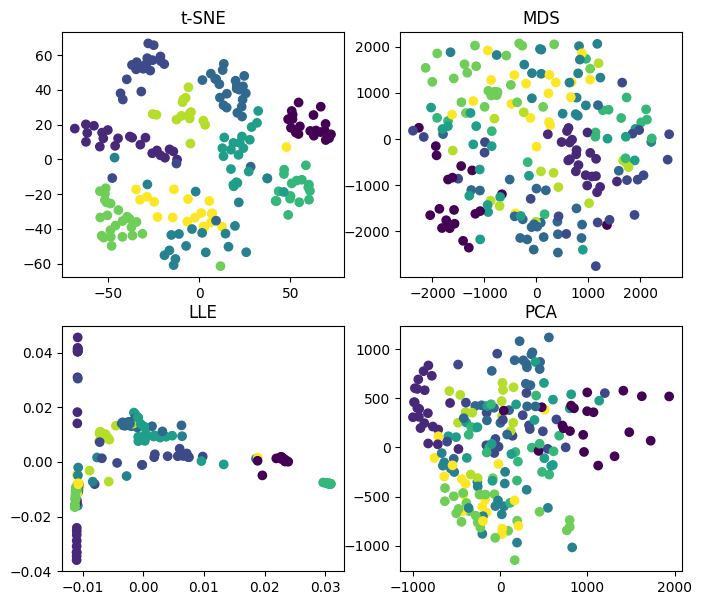

In [29]:
from sklearn.manifold import TSNE, MDS, LocallyLinearEmbedding

indexes = np.random.default_rng(seed=42).permutation(5000)
X_5k = X_train[:5000]
y_5k = y_train[:5000]

algorithms = [("t-SNE", TSNE(n_components=2, random_state=42, n_jobs=-1)),
("MDS", MDS(n_components=2, n_init=4, random_state=42, n_jobs=-1)),
("LLE", LocallyLinearEmbedding(n_components=2, random_state=42, n_jobs=-1)),
("PCA", PCA(n_components=2, random_state=42))]

fig, axs = plt.subplots(2,2, figsize=(8,7))
for i, (name, algorithm) in enumerate(algorithms):
    # print(i, name, algorithm)
    ax = axs[i//2, i%2]
    x_reduced = algorithm.fit_transform(X_5k)[indexes[:200]]
    ax.scatter(x_reduced[:,0], x_reduced[:,1], c=y_train[indexes[:200]])
    ax.set_title(name)
plt.show()

t-SNE did cluster same class instances together. MDS and PCA also kind of put same class instance close together. LLE's result is very weird; there is not much information in its graph.